# AdaBoost regression for simple linear and nonlinear function

In [73]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# linearOrNot can have value of 'linear', which is y=3*x, or 'nonlinear', which is y = x^2
# num_learners defines the number of weak learners that we have
# num_iterations defines the number of iterations we used to update the alphas
# 
# This function shows how to use adaboost to approximate a regression function, can be seen as you only have one feature
# We also want to find the relationship between accuracy and num_learners, and also num_iterations

def adaBoost (linearOrNot, num_learners, num_iterations):
    # create 200 training points
    if linearOrNot == 'linear':
        X = np.arange(20, 220, 1)
        y = 3*X
    elif linearOrNot == 'nonlinear':
        X = np.arange(0, 2, 0.01)
        y = X**2

    # create different learners
    # because the x value is evenly distributed, we can make threshold value in this way
    # otherwise you have to sort them first to get the quantiles
    num_samples = len(X) 
    stumps = np.zeros(num_samples)
    # sort the value of input and find different thresholds
    interval = int(num_samples / num_learners)
    quantile_idx = []
    for i in range(0, num_learners+1):
        quantile_idx.append(int(-1+i*interval))
    quantile_idx[0] = 0
    quantile_val = X[quantile_idx] # different quantile values

    # constructing the H matrix, where the columns correspond to different weak learners h(xi)
    H = []
    for idx in quantile_idx:
        if idx == 0:
            continue
        h = X > X[idx]
        H.append(h)
    H = np.array(H).T
    H = np.hstack([np.ones([num_samples,1]),H])
    
    # initialize the weights to be 0, including bias
    alphas = np.zeros(num_learners+1)

    # train the model
    for iteration in range(num_iterations):
        f = np.dot(H,alphas)
        r = y-f
        MSE = np.mean(r**2)
        # find the optimal direction
        idx = np.argmax(np.abs(np.dot(H.T,y-np.dot(H,alphas)))) # abs because alphas can go both directions
        # find the optimal step size
        step = np.dot(H[:,idx],r)/np.sum(H[:,idx]**2,axis=0)
        alphas[idx] += step
    
    print ('When the function is', linearOrNot)
    print ('Last MSE is', MSE)
    
    # calculate the cumulative weights
    cumu_alphas = []
    for i in range(2, len(alphas)+1):
        tmp = sum(alphas[1:i])
        cumu_alphas.append(tmp)

    # plot the graph
    plt.close("all")
    # center the y value to have a better visualization
    plt.plot(X,y-np.mean(y),'.',alpha=0.5,color=[0.9,0.9,0.9])
    pltx = np.hstack([quantile_val[0],np.tile(quantile_val[1:-1],[2,1]).T.reshape(-1),quantile_val[-1]])
    # center the y value to have a better visualization
    plty = np.tile(cumu_alphas, [2,1]).T.reshape(-1)-np.mean(cumu_alphas)
    plt.plot(pltx,plty)
    plt.title(linearOrNot)
    plt.xlim([X[0],X[-2]])
    plt.xlabel('data points')
    plt.ylabel('contribution to y')
    plt.plot(X,y)
    plt.show()
    
    y_hat = np.dot(H,alphas)
    return X, y, y_hat

When the function is linear
Last MSE is 843.3815266097813


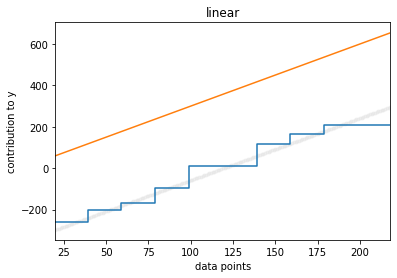

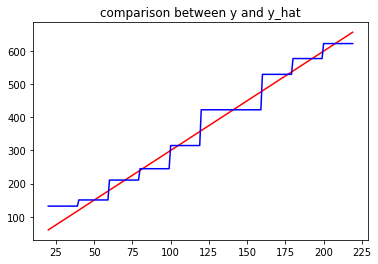

In [74]:
# First we tested the linear function, we can see that when we have only 10 learners, even though with 
# 3000 iterations, we still cannot approximate the linear function well. But if we have 100 learners, and 
# with 10000 iterations, we can see the adaboost model does a great job in fitting the linear line.

# So the number of weak learners are important for the accuracy of regression. If we have enough weak learners,
# with enough iterations, the model can somehow converge to a good performance.

X, y, y_hat = adaBoost('linear', 10, 30)
plt.plot(X, y, 'r')
plt.plot(X, y_hat, 'b')
plt.title('comparison between y and y_hat')
plt.show()

When the function is linear
Last MSE is 299.25


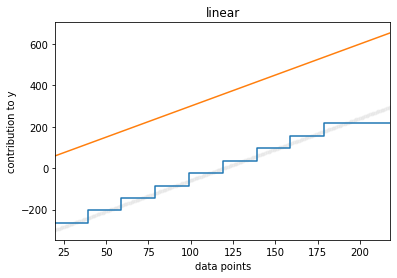

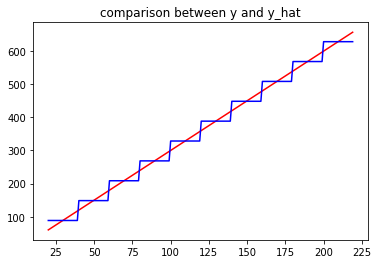

In [225]:
X, y, y_hat = adaBoost('linear', 10, 3000)
plt.plot(X, y, 'r')
plt.plot(X, y_hat, 'b')
plt.title('comparison between y and y_hat')
plt.show()

When the function is linear
Last MSE is 2.271188842252537


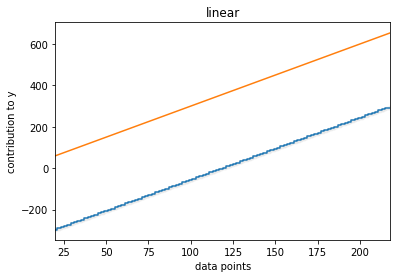

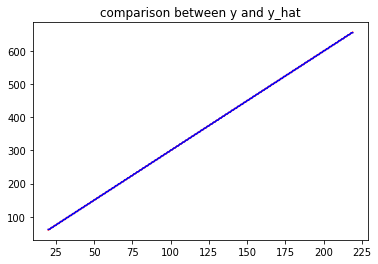

In [224]:
X, y, y_hat = adaBoost('linear', 100, 10000)
plt.plot(X, y, 'r')
plt.plot(X, y_hat, 'b')
plt.title('comparison between y and y_hat')
plt.show()

When the function is nonlinear
Last MSE is 0.0043648605


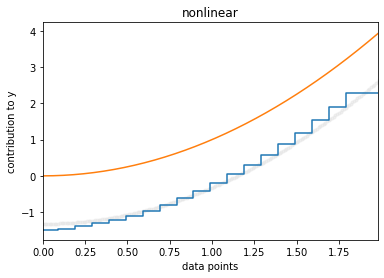

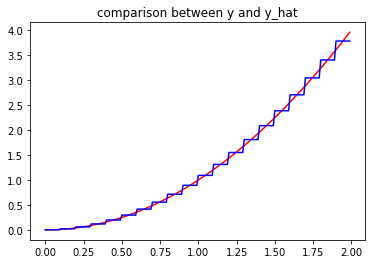

In [250]:
# Following the same logic, adaboost model can also approximate nonlinear function well 
X, y, y_hat = adaBoost('nonlinear', 20, 10000)
plt.plot(X, y, 'r')
plt.plot(X, y_hat, 'b')
plt.title('comparison between y and y_hat')
plt.show()

When the function is nonlinear
Last MSE is 0.00013321899157081897


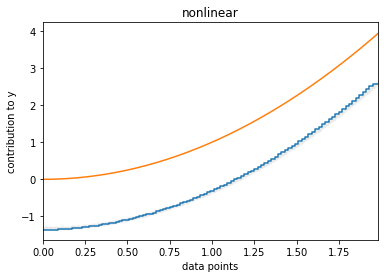

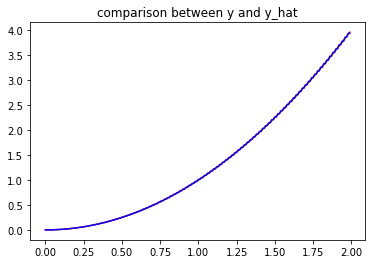

In [249]:
X, y, y_hat = adaBoost('nonlinear', 100, 10000)
plt.plot(X, y, 'r')
plt.plot(X, y_hat, 'b')
plt.title('comparison between y and y_hat')
plt.show()

# AdaBoost regression for more complex analysis on Cali housing price

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
%matplotlib inline

import sklearn
from sklearn.datasets import fetch_california_housing

plt.rcParams['font.size'] = 14

In [20]:
# Download data
tmp = sklearn.datasets.fetch_california_housing()
num_samples   = tmp['data'].shape[0] # 20640 data points
feature_names = tmp['feature_names'] # 8 features
y = tmp['target']
X = tmp['data'] # (20640, 8)
data = {} # a dictionary with each column corresponding to each feature
for n, feature in enumerate(feature_names):
    data[feature] = tmp['data'][:,n] # the n column

In [5]:
# y is already scaled down, 1 = $100000
print (min(y))
print (max(y))
print (np.mean(y))

0.14999
5.00001
2.068558169089147


In [6]:
# Create stumps

# bin the data by proportion, 10% in each bin
# bin contains threshold values
bins = {}
bin_idx = (np.arange(0,1.1,0.1)*num_samples).astype(np.int16)
bin_idx[-1] = bin_idx[-1]-1 # 20640 - 1 = 20639 in order to catach the last element
# bin_idx = array([    0,  2064,  4128,  6192,  8256, 10320, 12384, 14448, 16512, 18576, 20639], dtype=int16)
for feature in (feature_names):
    bins[feature] = np.sort(data[feature])[bin_idx]
    
# decision stumps as weak learners
# 0 if not in bin, 1 if in bin
stumps = {}
for feature in feature_names:
    stumps[feature] = np.zeros([num_samples,len(bins[feature])-1]) # should have 10 for each feature
    for n in range(len(bins[feature])-1):
        stumps[feature][:,n] = data[feature] > bins[feature][n]
# stumps['MedInc'].shape (20640, 10)
# every weak learners should assign {1,0} to total of 20640 data points

# stack the weak classifier outcomes into a matrix
H = np.hstack([stumps[feature] for feature in feature_names]) # added to the right
H = np.hstack([np.ones([num_samples,1]),H]) # 20640, 81
alphas = np.zeros(H.shape[1]) # 8 * 10 + 1 bias = 81 weights

In [7]:
num_iterations = 30
MSE = np.zeros(num_iterations) # track mean square error

for iteration in range(num_iterations):
    f = np.dot(H,alphas) # will have 20640 x 1 results
    r = y-f; MSE[iteration] = np.mean(r**2)
    idx = np.argmax(np.abs(np.dot(H.T,y-np.dot(H,alphas)))) # should use the absolue sign
    alphas[idx] = alphas[idx] + np.dot(H[:,idx],r)/np.sum(H[:,idx]**2,axis=0)

In [8]:
# decision stumps as weak learners
# 0 if not in bin, 1 if in bin
stumps = {}
for feature in feature_names:
    stumps[feature] = np.zeros([num_samples,len(bins[feature])-1]) # should have 10 for each feature
    for n in range(len(bins[feature])-1):
        stumps[feature][:,n] = data[feature] > bins[feature][n]
# stumps['MedInc'].shape (20640, 10)
# every weak learners should assign {1,0} to total of 20640 data points

# stack the weak classifier outcomes into a matrix
H = np.hstack([stumps[feature] for feature in feature_names]) # added to the right
H = np.hstack([np.ones([num_samples,1]),H]) # 20640, 81

In [9]:
# weights associated with each learner
alphasf = {}
start = 1
for feature in feature_names:
    alphasf[feature] = alphas[start:(start+stumps[feature].shape[1])]
    start = start + stumps[feature].shape[1]
alphasf['mean'] = alphas[0] # bias weight

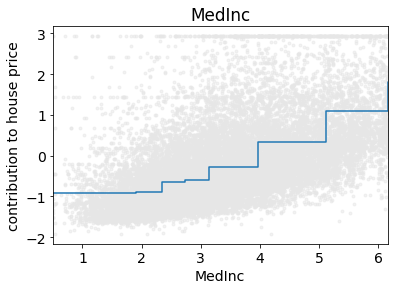

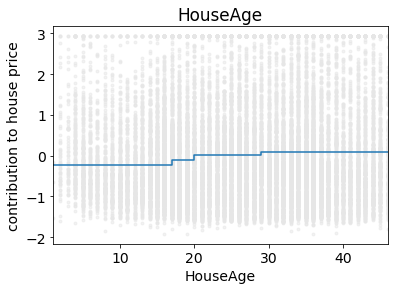

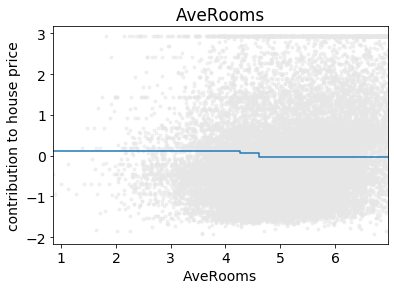

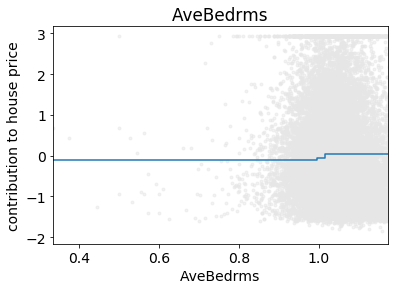

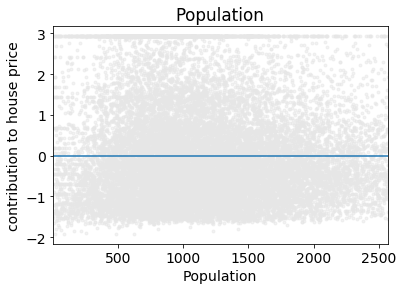

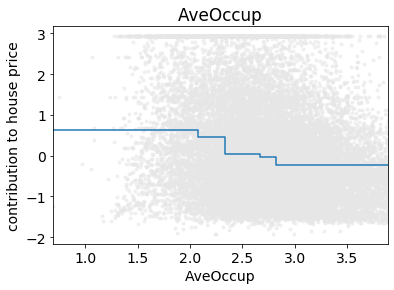

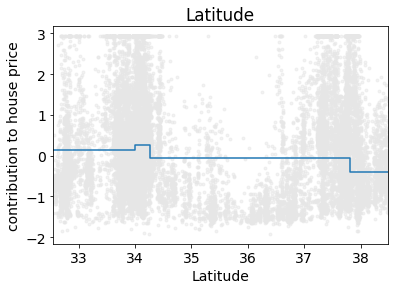

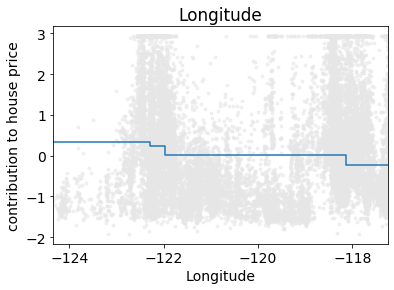

In [10]:
for feature in feature_names:
    plt.close("all")
    plt.plot(data[feature],y-np.mean(y),'.',alpha=0.5,color=[0.9,0.9,0.9])
    pltx = np.hstack([bins[feature][0],np.tile(bins[feature][1:-1],[2,1]).T.reshape(-1),bins[feature][-1]])
    plty = np.tile(np.cumsum(alphasf[feature]),[2,1]).T.reshape(-1)-np.mean(np.cumsum(alphasf[feature]))
    plt.plot(pltx,plty)
    plt.title(feature)
    plt.xlim([bins[feature][0],bins[feature][-2]]) # only for visualization purpose
    plt.xlabel(feature)
    plt.ylabel('contribution to house price')
    plt.show()

# dissection

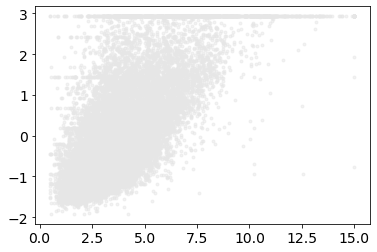

In [11]:
# x is the feature value, y is the y values that centered at 0
# the same feature value may correspond to different y values
plt.plot(data['MedInc'],y-np.mean(y),'.',alpha=0.5,color=[0.9,0.9,0.9])

In [12]:
print (min(data['MedInc']))
max(data['MedInc'])

0.4999


15.0001

In [13]:
# stack the threshold values
# each interval corresponds a weak learner, want to find the assoicated weight
# so each threshold value should show up twice to consider both the left part and right part weights
np.hstack([bins['MedInc'][0],np.tile(bins['MedInc'][1:-1],[2,1]).T.reshape(-1),bins['MedInc'][-1]])

array([ 0.4999,  1.9038,  1.9038,  2.3523,  2.3523,  2.7401,  2.7401,
        3.1406,  3.1406,  3.5349,  3.5349,  3.9673,  3.9673,  4.4375,
        4.4375,  5.1098,  5.1098,  6.1593,  6.1593, 15.0001])

In [14]:
# give weights to different intervals
# center the data to make it within the visual range with the y values
np.tile(np.cumsum(alphasf[feature]),[2,1]).T.reshape(-1)-np.mean(np.cumsum(alphasf[feature]))

array([ 0.33482624,  0.33482624,  0.23545066,  0.23545066,  0.01982941,
        0.01982941,  0.01982941,  0.01982941,  0.01982941,  0.01982941,
        0.01982941,  0.01982941,  0.01982941,  0.01982941, -0.22314131,
       -0.22314131, -0.22314131, -0.22314131, -0.22314131, -0.22314131])

# Split into training and testing data to see how it performs

iterations: 0
training MSE: 5.610499396753208
testing MSE: 1.3336097079208389
iterations: 10
training MSE: 0.6692458875472919
testing MSE: 0.6840851958302541
iterations: 20
training MSE: 0.5146697280126594
testing MSE: 0.5483362063269233
iterations: 30
training MSE: 0.48922443337490623
testing MSE: 0.5225191426644861
iterations: 40
training MSE: 0.47373679731894547
testing MSE: 0.5094954221442342
iterations: 50
training MSE: 0.45676455547552725
testing MSE: 0.48866977174734577
iterations: 60
training MSE: 0.4480417615617685
testing MSE: 0.48009202421587815
iterations: 70
training MSE: 0.44392410675364424
testing MSE: 0.4757108918278159
iterations: 80
training MSE: 0.43927885502173414
testing MSE: 0.471064933377196
iterations: 90
training MSE: 0.435811478844374
testing MSE: 0.4665161935901309
iterations: 100
training MSE: 0.43216537618433476
testing MSE: 0.46226715864448714
iterations: 110
training MSE: 0.4300307453631894
testing MSE: 0.4595772642746202


/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

iterations: 120
training MSE: 0.42836972254342526
testing MSE: 0.45733474989703593
iterations: 130
training MSE: 0.42670712490339924
testing MSE: 0.4558335003735435
iterations: 140
training MSE: 0.42453911831010926
testing MSE: 0.45273006337895866


/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

iterations: 150
training MSE: 0.4203593355874423
testing MSE: 0.44993095533449723
iterations: 160
training MSE: 0.41898651998457104
testing MSE: 0.4489065574347161
iterations: 170
training MSE: 0.4174887083363596
testing MSE: 0.4473246964718841


/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

iterations: 180
training MSE: 0.416379321007494
testing MSE: 0.44619100953446067
iterations: 190
training MSE: 0.41517690017765546


/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

testing MSE: 0.4451747921594294
iterations: 200
training MSE: 0.4142465709526657
testing MSE: 0.44402149313147277


/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

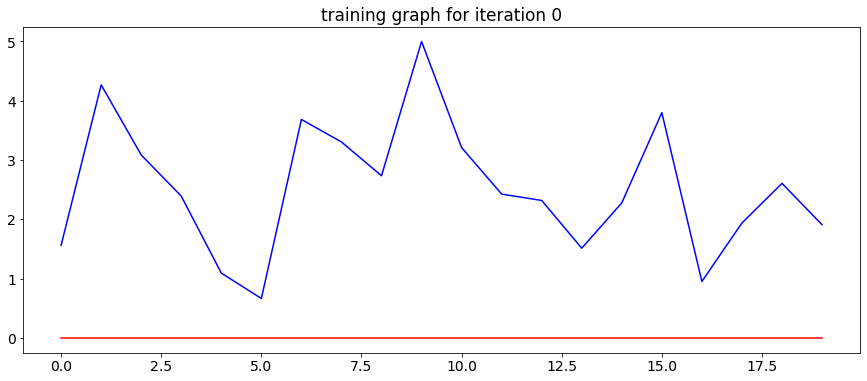

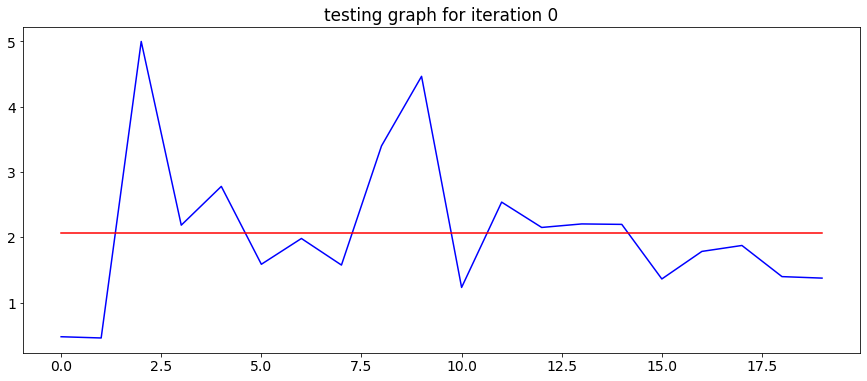

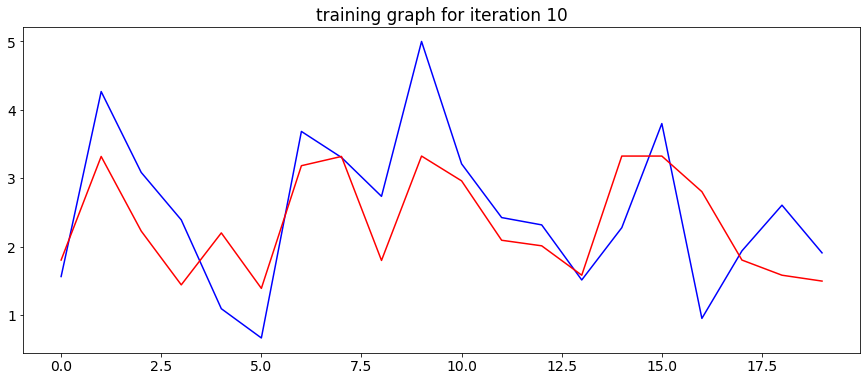

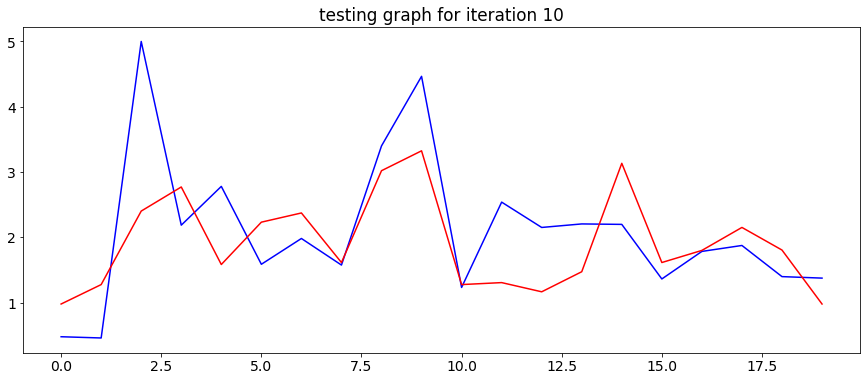

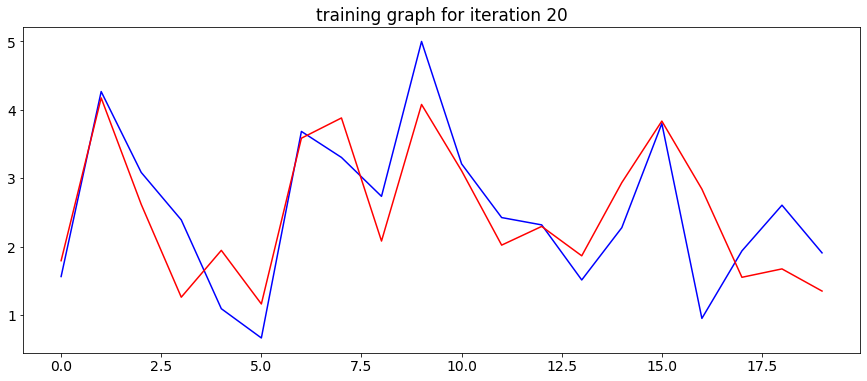

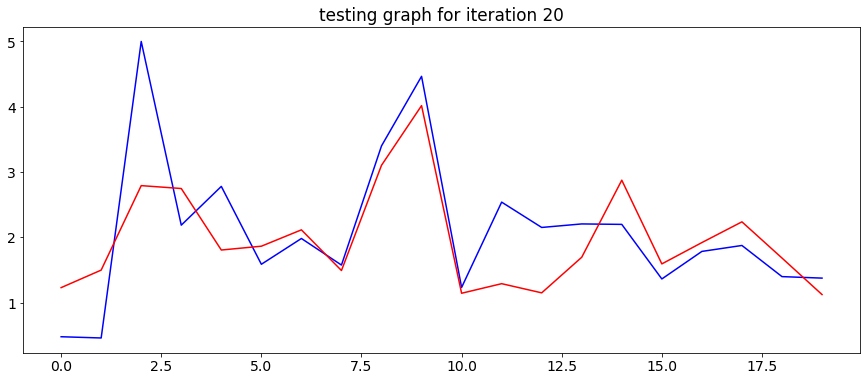

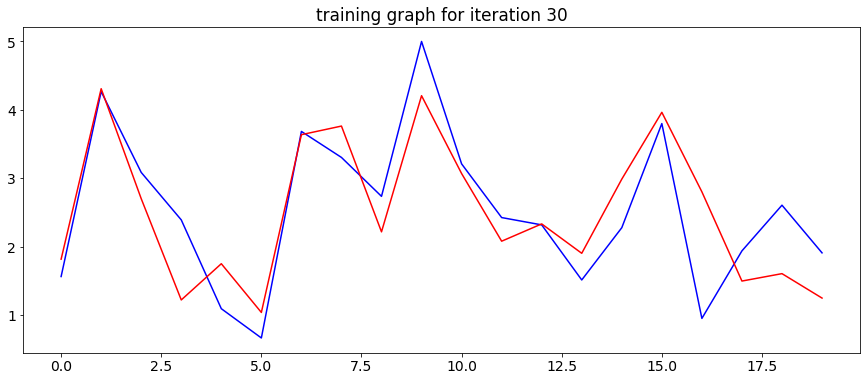

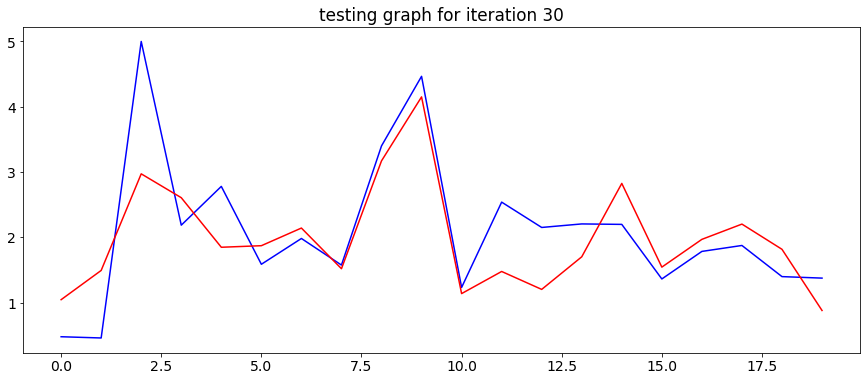

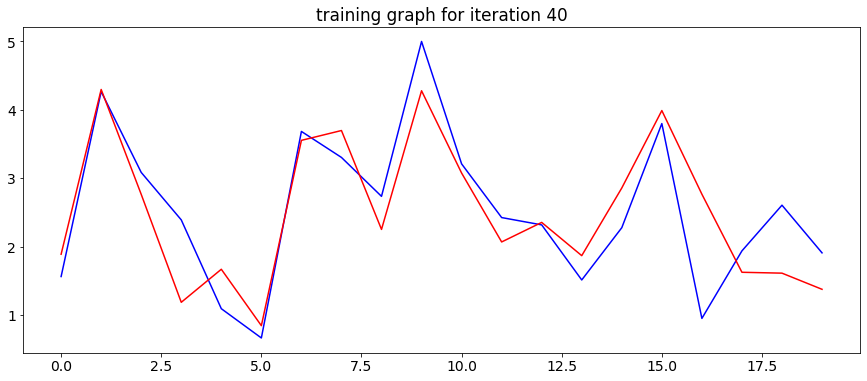

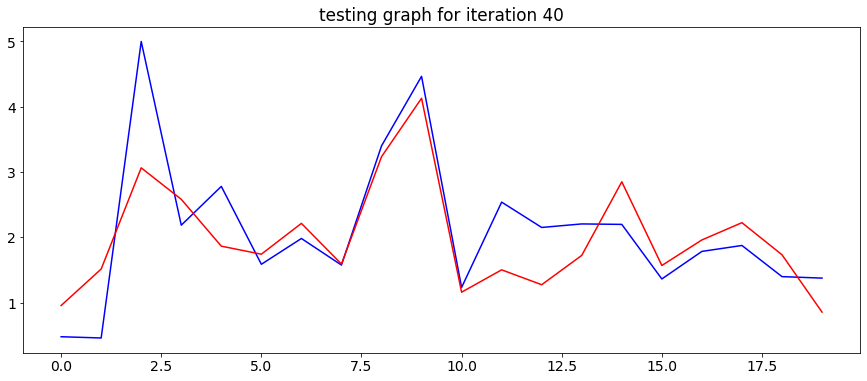

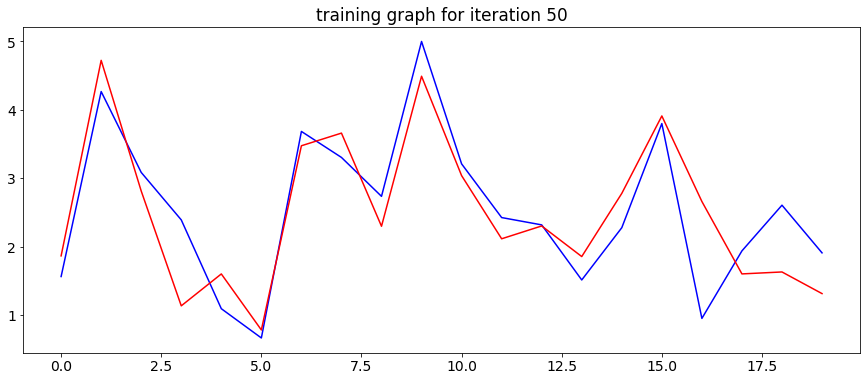

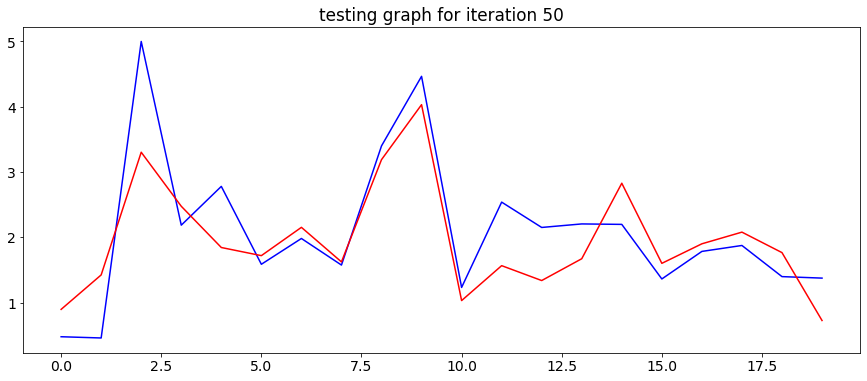

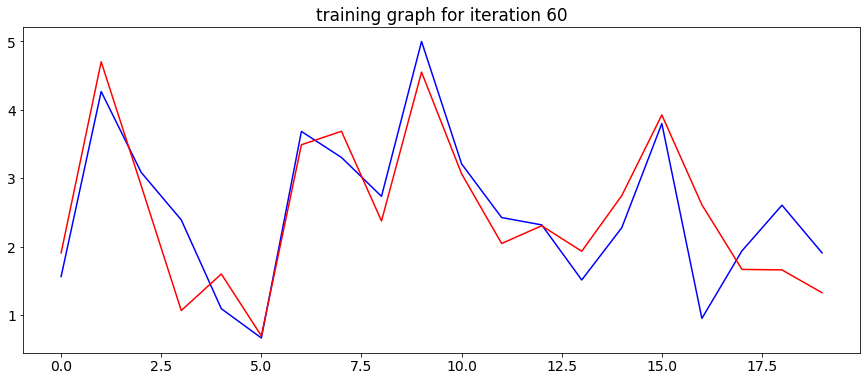

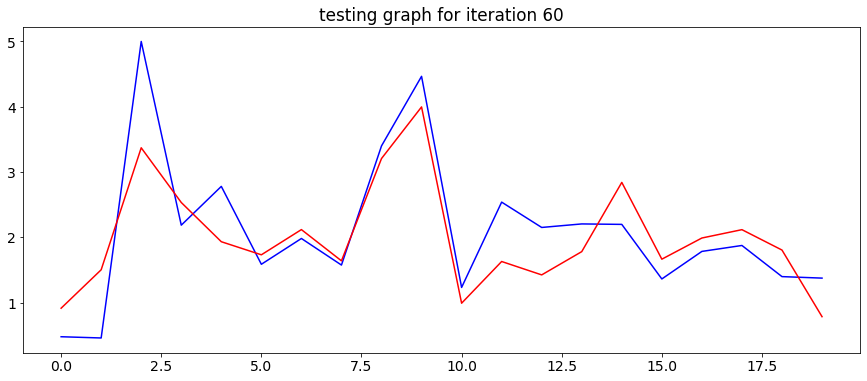

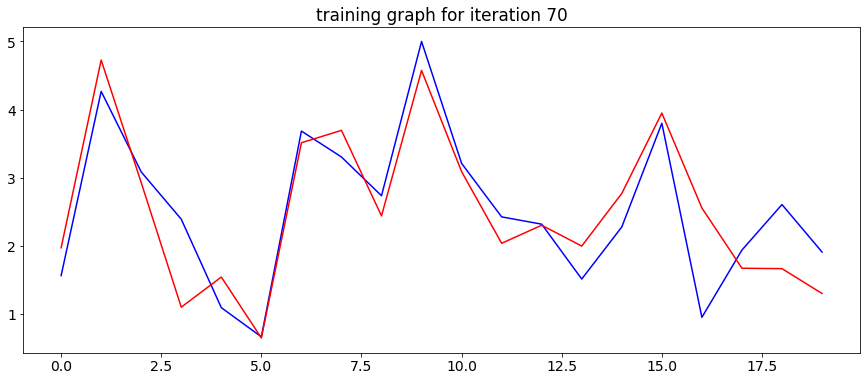

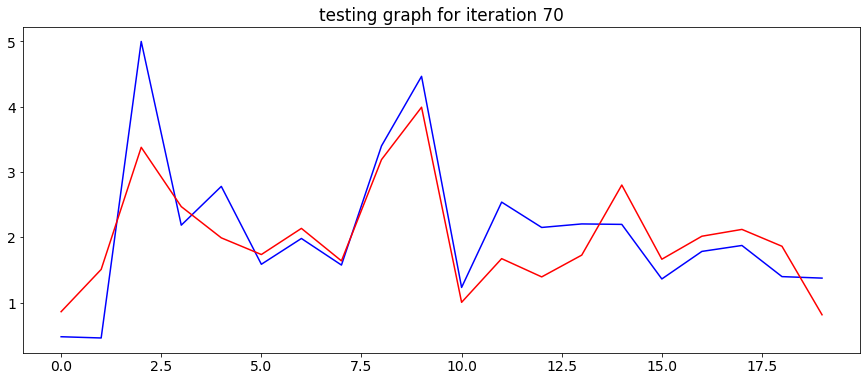

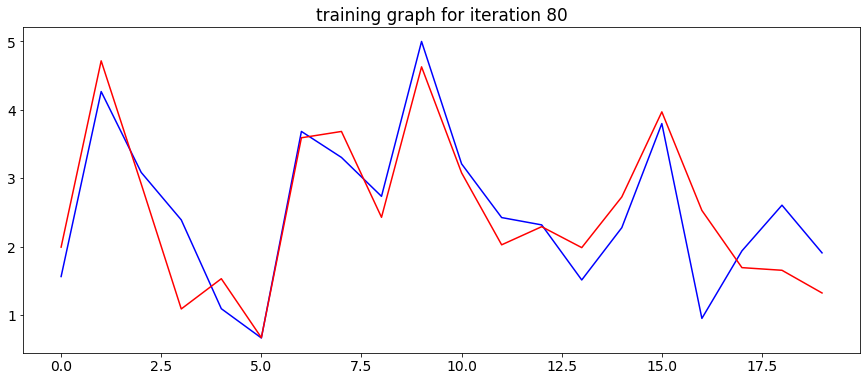

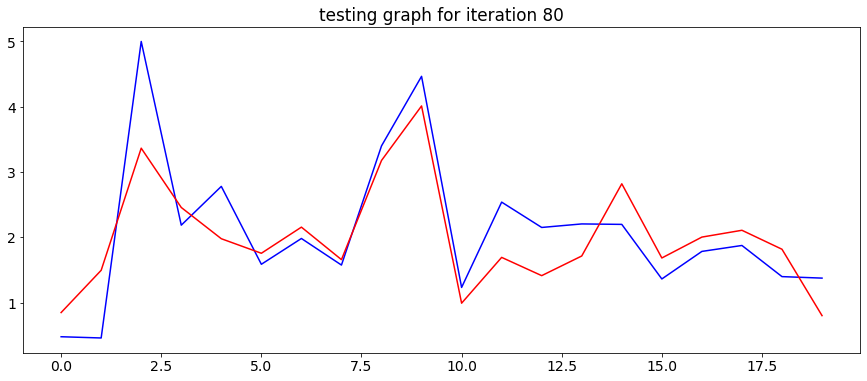

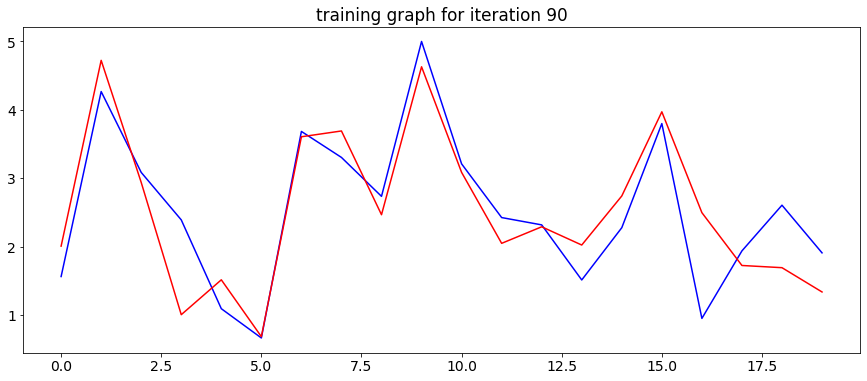

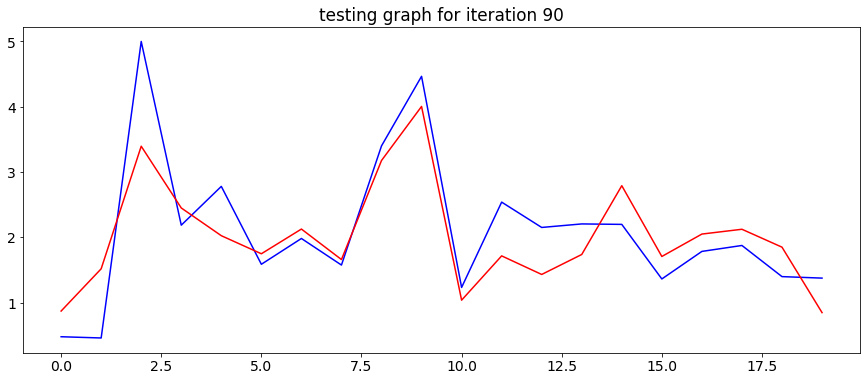

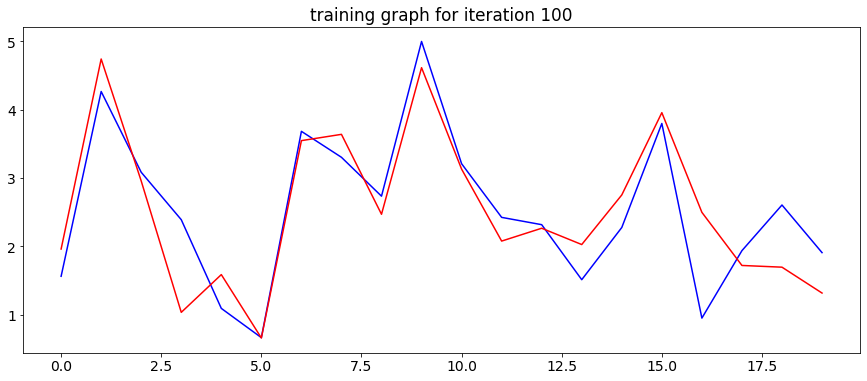

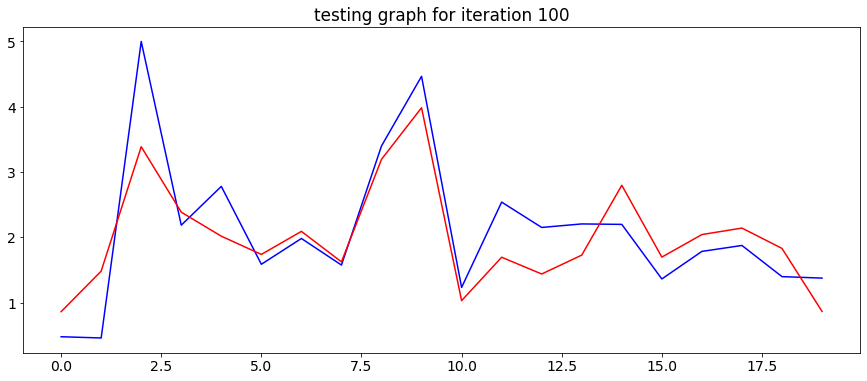

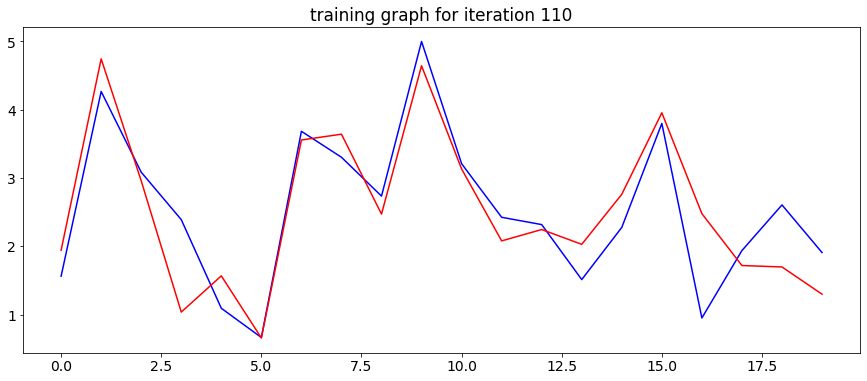

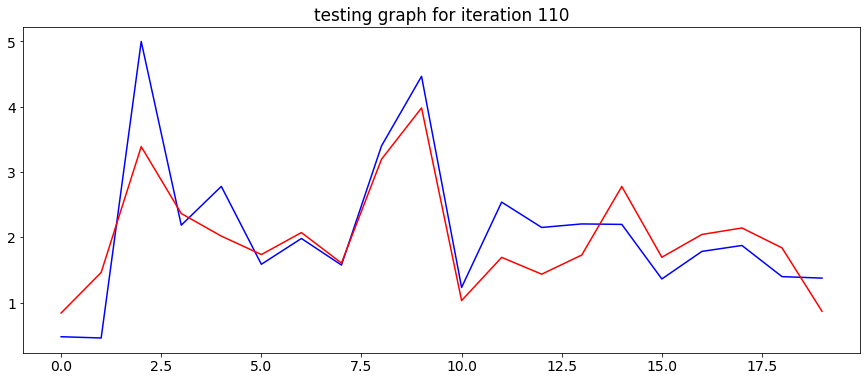

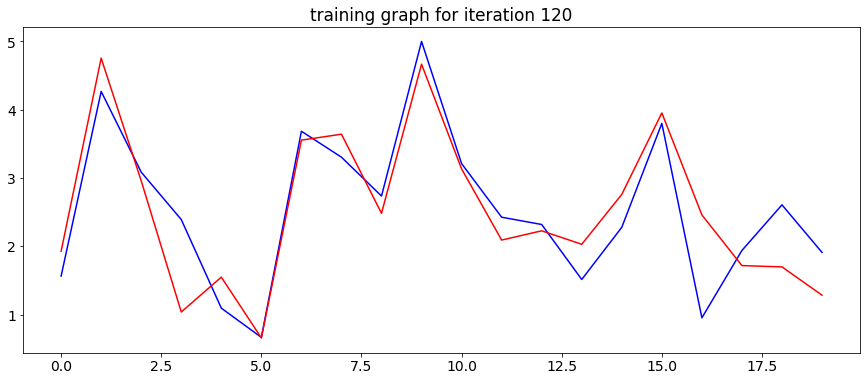

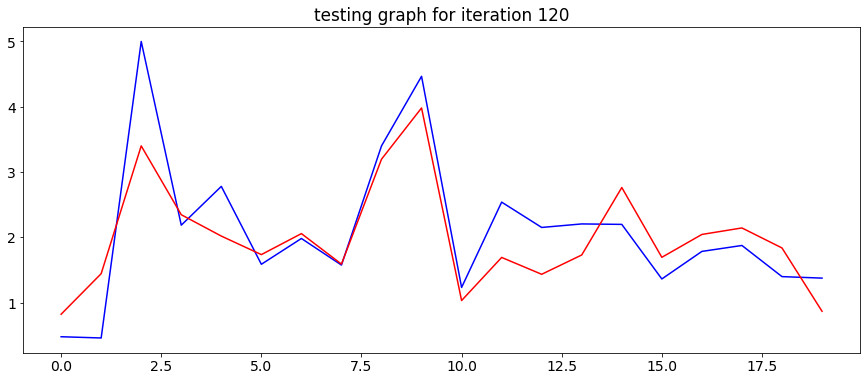

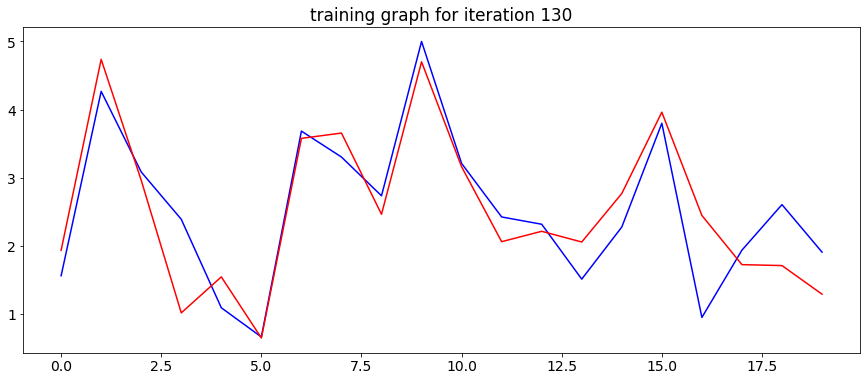

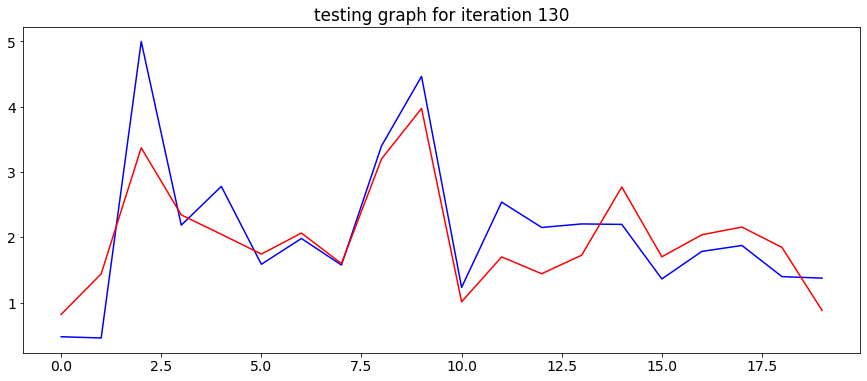

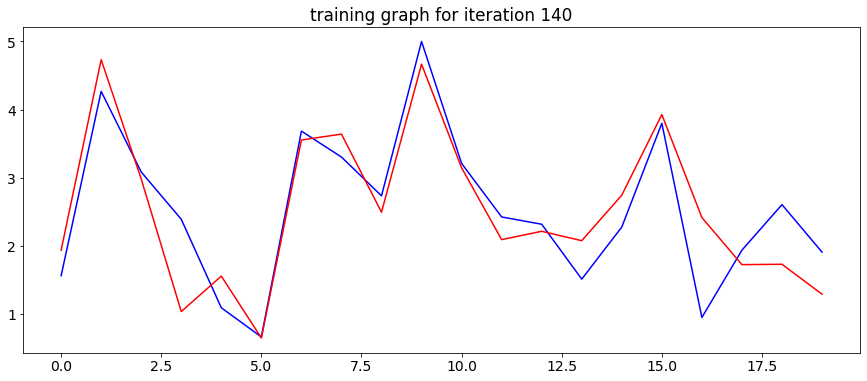

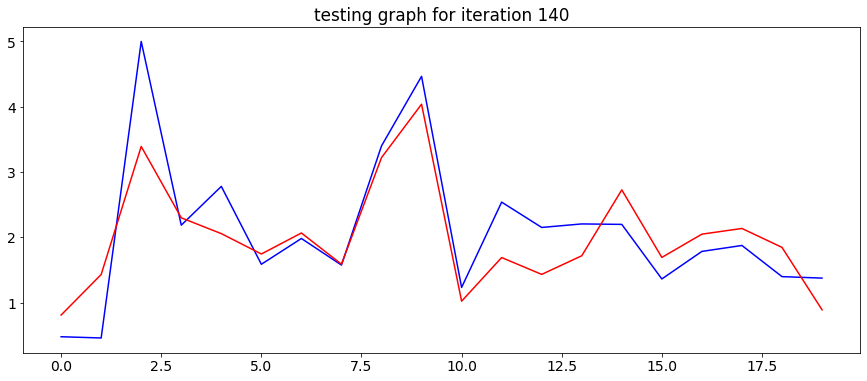

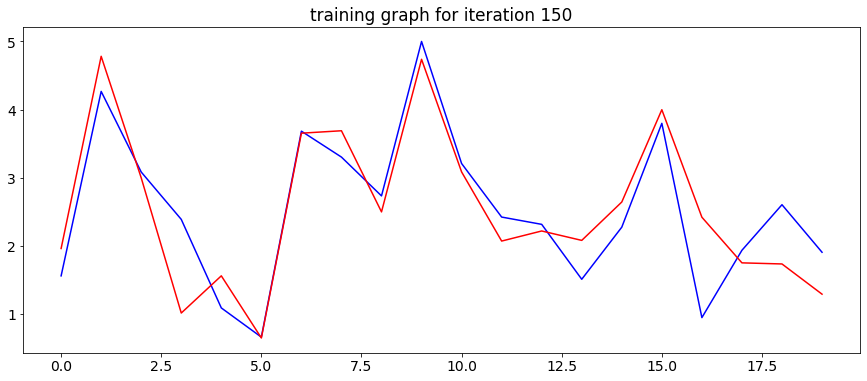

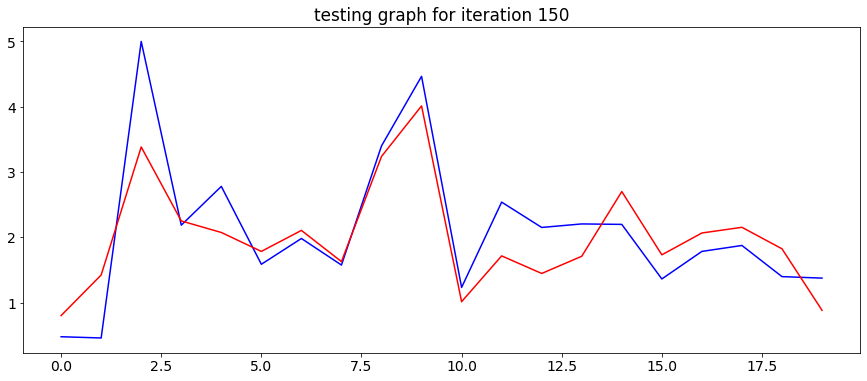

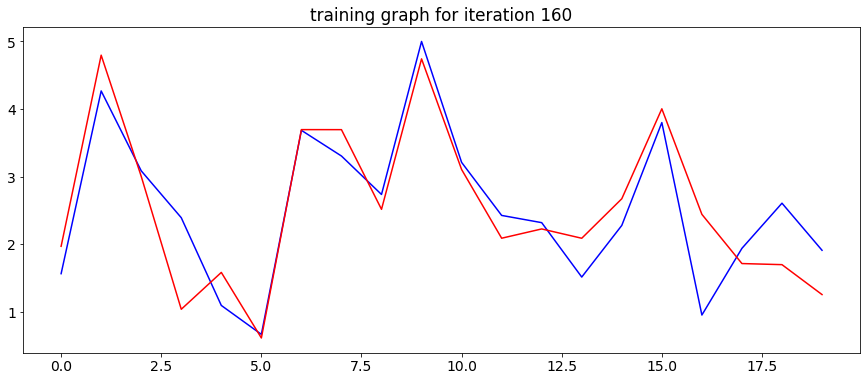

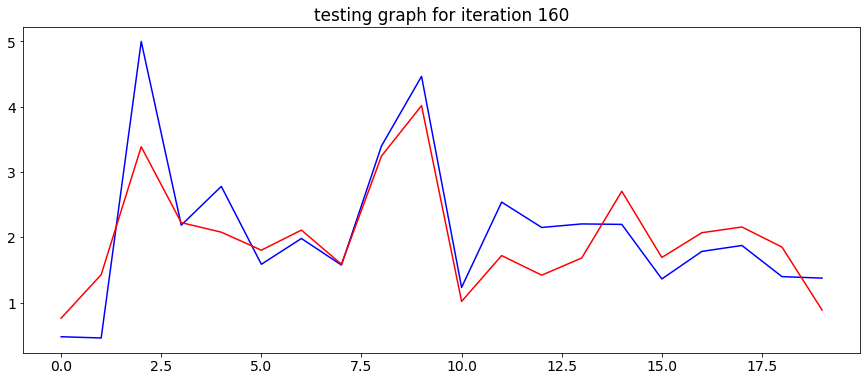

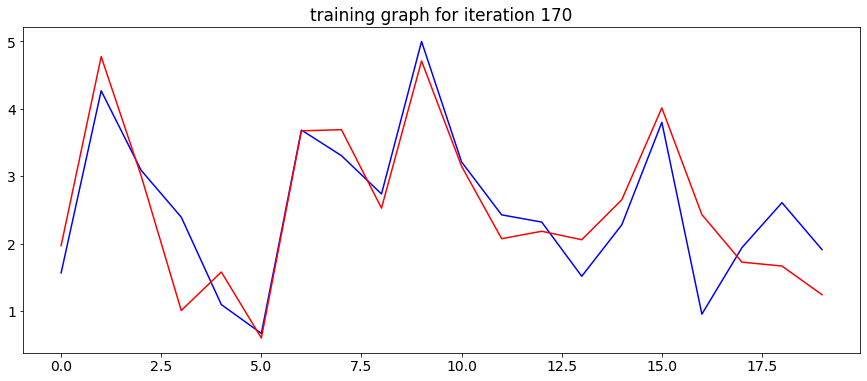

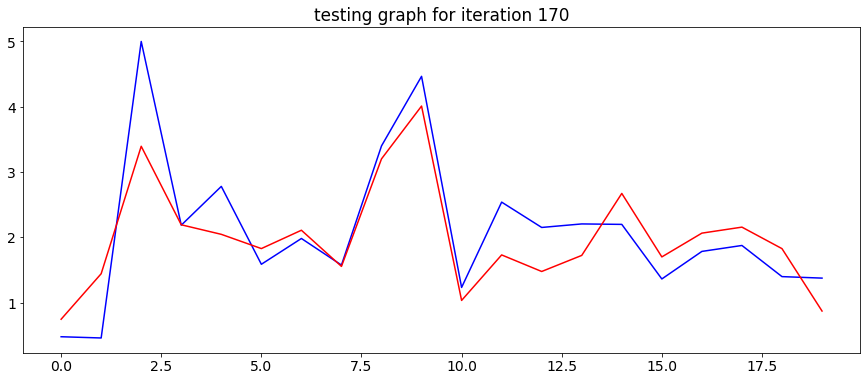

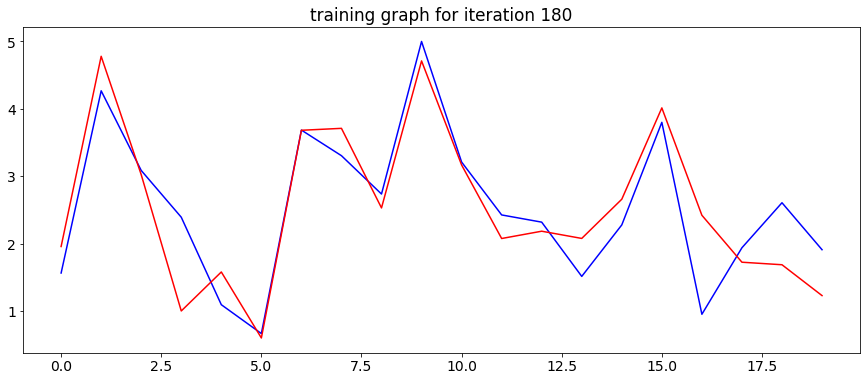

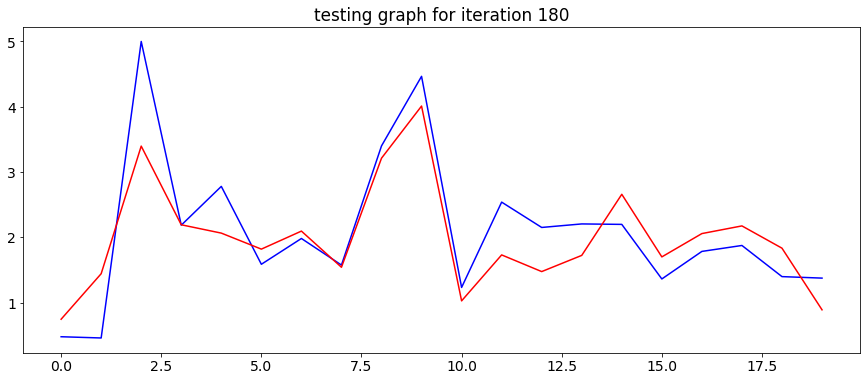

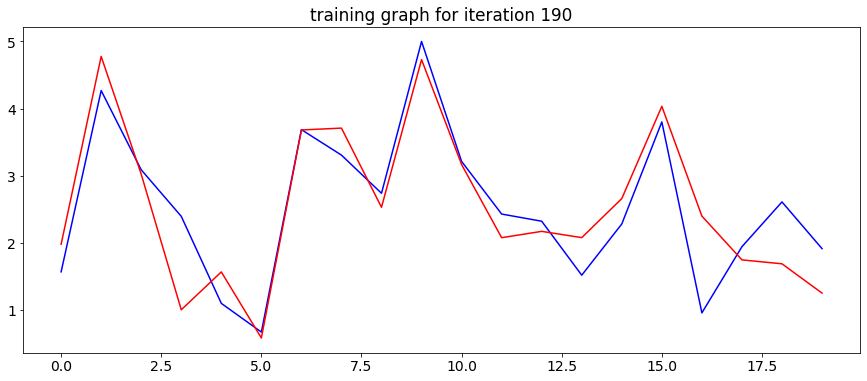

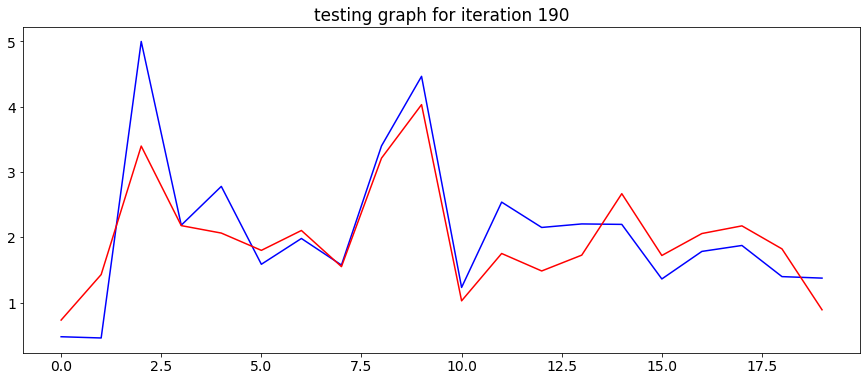

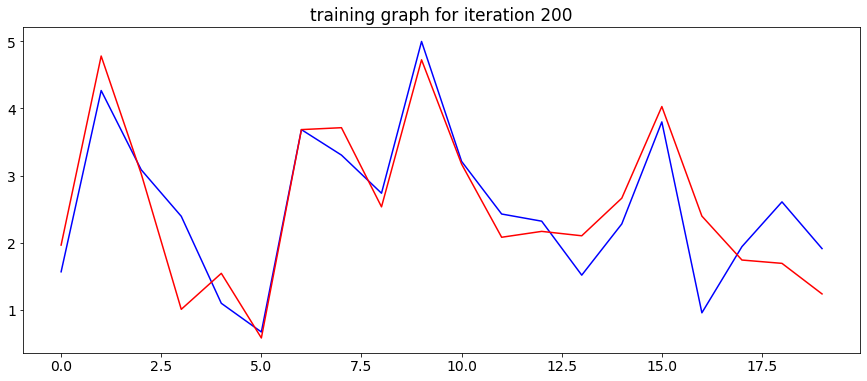

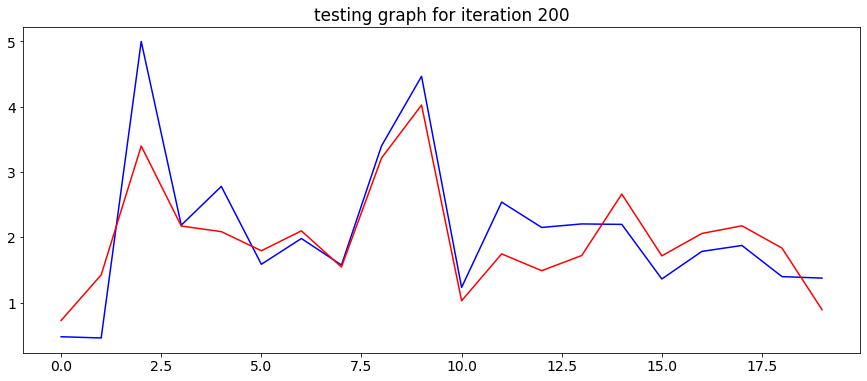

In [58]:
from sklearn.model_selection import train_test_split
feature_names = tmp['feature_names']
y = tmp['target']
X = tmp['data']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# training

num_samples = X_train.shape[0]
data = {}
for n, feature in enumerate(feature_names):
    data[feature] = X_train[:,n]

bins = {}
bin_idx = (np.arange(0,1.1,0.1)*num_samples).astype(np.int16)
bin_idx[-1] = bin_idx[-1]-1 
for feature in (feature_names):
    bins[feature] = np.sort(data[feature])[bin_idx]
    
stumps = {}
for feature in feature_names:
    stumps[feature] = np.zeros([num_samples,len(bins[feature])-1])
    for n in range(len(bins[feature])-1):
        stumps[feature][:,n] = data[feature] > bins[feature][n]

H = np.hstack([stumps[feature] for feature in feature_names])
H = np.hstack([np.ones([num_samples,1]),H])
alphas = np.zeros(H.shape[1])
# alphas are the weights we need on testing

num_iterations = 201
MSE = np.zeros(num_iterations)

y = y_train

for iteration in range(num_iterations):
    f = np.dot(H,alphas)
    r = y-f; MSE[iteration] = np.mean(r**2)
    idx = np.argmax(np.abs(np.dot(H.T,y-np.dot(H,alphas))))
    alphas[idx] = alphas[idx] + np.dot(H[:,idx],r)/np.sum(H[:,idx]**2,axis=0)
    # test within training process
    if iteration % 10 == 0:
        print ('iterations:', iteration)
        print ('training MSE:', MSE[iteration])
        test_num_samples = X_test.shape[0]
        test_data = {}
        for n, feature in enumerate(feature_names):
            test_data[feature] = X_test[:,n]

        # share the same bins and same threshold values
        test_stumps = {}
        for feature in feature_names:
            test_stumps[feature] = np.zeros([test_num_samples,len(bins[feature])-1]) # should have 10 for each feature
            for n in range(len(bins[feature])-1):
                test_stumps[feature][:,n] = test_data[feature] > bins[feature][n]

        # stack the weak classifier outcomes into a matrix
        test_H = np.hstack([test_stumps[feature] for feature in feature_names])
        test_H = np.hstack([np.ones([test_num_samples,1]),test_H])
        
        plt.figure(0)
        plt.figure(figsize=(15,6))
        plt.title('training graph for iteration ' +  str(iteration))
        plt.plot(y[0:20], 'b')
        plt.plot(f[0:20], 'r')

        y_hat = np.dot(test_H, alphas)
        print ('testing MSE:', np.mean((y_test-y_hat)**2))
        plt.figure(1)
        plt.figure(figsize=(15,6))
        plt.title('testing graph for iteration ' +  str(iteration))
        plt.plot(y_test[0:20], 'b')
        plt.plot(y_hat[0:20], 'r')



# Calculate variable importance

In [259]:
print('Variable Importance')

for feature_no, feature in enumerate(feature_names):
    H2 = np.array(H)
    H2[np.random.permutation(num_samples),(feature_no*10+1):((feature_no+1)*10+1)] = H[:,(feature_no*10+1):((feature_no+1)*10+1)]
    f = np.dot(H2,alphas)
    r = y-f;
    print(feature,', error: %.2f'%(np.mean(r**2)))

Variable Importance
MedInc , error: 1.91
HouseAge , error: 0.53
AveRooms , error: 0.51
AveBedrms , error: 0.50
Population , error: 0.49
AveOccup , error: 0.68
Latitude , error: 0.62
Longitude , error: 0.58


In [260]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [261]:
clf = GradientBoostingRegressor(loss="ls")
clf.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/Users/wiwiying/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(

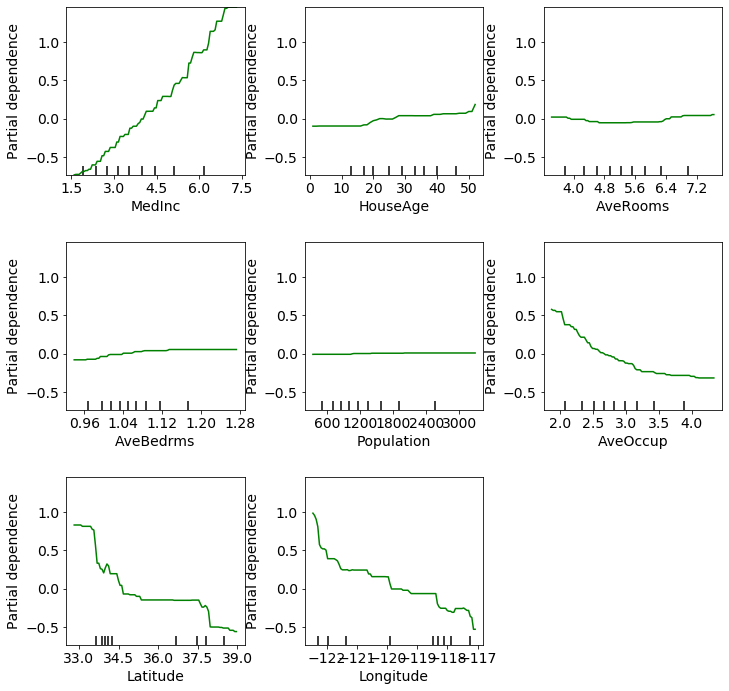

In [262]:
plt.close("all")
plt.figure(figsize=[10,10])
ax = plt.gca()
plot_partial_dependence(clf, X, feature_names, feature_names, n_cols=3, ax=ax) 
plt.tight_layout()
plt.show()

In [263]:
from sklearn.linear_model import LinearRegression

In [264]:
clf2 = LinearRegression()
clf2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [265]:
print ('linear regression error', np.mean((y-clf2.predict(X))**2))

linear regression error 0.5243209861846071


In [266]:
print ('boosting error', np.mean((y-clf.predict(X))**2))

boosting error 0.26188431965892933
